In [122]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [123]:
data = pd.read_csv("HaNoi.csv", parse_dates=["date"], dayfirst=True, index_col=["date"])
data = data.sort_index()
start_date = '2019-03-01'
end_date = '2024-03-01'
df = data.loc[start_date:end_date]
df

,Index,pm25,pm10,o3,no2,so2,co,AQI
date,,,,,,,,
2019-05-03,1171,65,39,13,17,13,12,65
2019-05-04,1174,65,39,17,17,13,12,65
2019-05-05,1175,65,39,71,17,13,12,71
2019-05-06,1176,65,39,24,17,13,12,65
2019-05-07,1177,65,39,56,17,13,12,65
...,...,...,...,...,...,...,...,...
2024-02-26,2743,62,26,6,3,8,4,62
2024-02-27,2744,47,43,5,3,8,6,47
2024-02-28,2745,86,29,9,2,8,4,86


In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1695 entries, 2019-05-03 to 2024-03-01
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Index   1695 non-null   int64
 1   pm25    1695 non-null   int64
 2   pm10    1695 non-null   int64
 3   o3      1695 non-null   int64
 4   no2     1695 non-null   int64
 5   so2     1695 non-null   int64
 6   co      1695 non-null   int64
 7   AQI     1695 non-null   int64
dtypes: int64(8)
memory usage: 119.2 KB


In [125]:
df_aqi = pd.DataFrame(df["AQI"])

In [126]:
timesteps = df_aqi.index.values
aqi_arr = df_aqi["AQI"].values

In [127]:
timesteps

array(['2019-05-03T00:00:00.000000000', '2019-05-04T00:00:00.000000000',
       '2019-05-05T00:00:00.000000000', ...,
       '2024-02-28T00:00:00.000000000', '2024-02-29T00:00:00.000000000',
       '2024-03-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [128]:
aqi_arr

array([65, 65, 71, ..., 86, 55, 46])

**Building and testing he N-BEATS block layer**

In [129]:
class NBeatsBlock(tf.keras.layers.Layer):

  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon:    int,
               n_neurons:  int,
               n_layers:   int,
               **kwargs):


    super().__init__(**kwargs)
    self.input_size= input_size
    self.theta_size= theta_size
    self.horizon = horizon
    self.n_neurons= n_neurons
    self.n_layers= n_layers

    self.hidden=[tf.keras.layers.Dense(n_neurons, activation='relu', name=f"Fully_Connected_Layer_{i}") for i in range(1,n_layers+1) ]
    self.theta_layer=tf.keras.layers.Dense(theta_size, activation='linear',name='theta')


  def call(self,inputs):

    x= inputs

    for layer in self.hidden :
      x= layer(x)

    theta= self.theta_layer(x)

    # output the backcast and forecast
    backcast, forecast = theta[:,:self.input_size], theta[:,-self.horizon:]
    return backcast, forecast


**Making dummy inputs and outputs for testing our NBeatsBlock class**

In [130]:
WINDOW_SIZE=100
HORIZON=1
tf.random.set_seed(42)
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=HORIZON+WINDOW_SIZE,
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE)+1, axis=0)
dummy_inputs


# passing dummy inputs
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)

print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")



Backcast: [  1.0162826  -25.773674   -19.592848     8.351507     1.4160404
   8.779907    23.31538     11.869641    30.232912    11.333768
  -1.6208037   38.78732    -15.048498     2.6642652   -1.8168383
  -9.203208    10.35202     10.347623    14.943665     8.557804
   6.4139013    1.540976    -3.1142642   -3.2897673  -11.127082
 -21.3102      -4.6301003    4.8668346  -10.306218   -28.344448
   4.186165    -0.44437766  -7.0227103    8.523539     2.9308538
  -9.218657   -24.289547   -10.784107     2.096515    -6.863154
   4.7030272  -14.832219    -8.136823   -17.243778   -13.525852
 -14.6623125  -10.417423     9.219715   -12.463509   -12.275621
  -2.0992043   13.366401   -13.587252     1.01439    -21.829567
 -10.702358     9.552027   -14.284834     5.166669   -12.880393
   7.214692    16.161953     8.131272   -10.314012   -29.00755
 -11.48318    -28.640533    16.526747    -2.670141     3.056564
   5.020667    -6.073318   -15.602494    -4.909899     6.2159853
  17.796179   -46.245575   

**Preparing data for the N-BEATS algorithm using tf.data**

In [131]:
WINDOW_SIZE=90
HORIZON=1
df_aqi

,AQI
date,
2019-05-03,65
2019-05-04,65
2019-05-05,71
2019-05-06,65
2019-05-07,65
...,...
2024-02-26,62
2024-02-27,47
2024-02-28,86


In [132]:
aqi_nbeats = df_aqi.copy()
for i in range(WINDOW_SIZE):
  aqi_nbeats[f"AQI+{i+1}"] = aqi_nbeats["AQI"].shift(periods=i+1)
aqi_nbeats.dropna()

,AQI,AQI+1,AQI+2,AQI+3,AQI+4,AQI+5,AQI+6,AQI+7,AQI+8,AQI+9,...,AQI+81,AQI+82,AQI+83,AQI+84,AQI+85,AQI+86,AQI+87,AQI+88,AQI+89,AQI+90
date,,,,,,,,,,,,,,,,,,,,,
2019-08-03,18,17.0,17.0,21.0,34.0,50.0,50.0,50.0,29.0,28.0,...,65.0,65.0,65.0,65.0,65.0,65.0,65.0,71.0,65.0,65.0
2019-08-04,29,18.0,17.0,17.0,21.0,34.0,50.0,50.0,50.0,29.0,...,65.0,65.0,65.0,65.0,65.0,65.0,65.0,65.0,71.0,65.0
2019-08-05,50,29.0,18.0,17.0,17.0,21.0,34.0,50.0,50.0,50.0,...,65.0,65.0,65.0,65.0,65.0,65.0,65.0,65.0,65.0,71.0
2019-08-06,50,50.0,29.0,18.0,17.0,17.0,21.0,34.0,50.0,50.0,...,65.0,65.0,65.0,65.0,65.0,65.0,65.0,65.0,65.0,65.0
2019-08-07,50,50.0,50.0,29.0,18.0,17.0,17.0,21.0,34.0,50.0,...,65.0,65.0,65.0,65.0,65.0,65.0,65.0,65.0,65.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-26,62,38.0,38.0,96.0,70.0,78.0,75.0,57.0,68.0,89.0,...,65.0,172.0,187.0,164.0,160.0,137.0,140.0,150.0,152.0,187.0
2024-02-27,47,62.0,38.0,38.0,96.0,70.0,78.0,75.0,57.0,68.0,...,103.0,65.0,172.0,187.0,164.0,160.0,137.0,140.0,150.0,152.0
2024-02-28,86,47.0,62.0,38.0,38.0,96.0,70.0,78.0,75.0,57.0,...,107.0,103.0,65.0,172.0,187.0,164.0,160.0,137.0,140.0,150.0


**NBEATS(7:3)**

In [133]:
# Make features and labels
x = aqi_nbeats.drop("AQI", axis=1)
y = aqi_nbeats["AQI"]
x.fillna(method='ffill', inplace=True)
x.fillna(method='bfill', inplace=True)
y.fillna(method='ffill', inplace=True)
y.fillna(method='bfill', inplace=True)

In [134]:
split_size = int(len(x) * 0.7)
x_train, y_train = x[:split_size], y[:split_size]
x_test, y_test = x[split_size:], y[split_size:]
len(x_train), len(y_train), len(x_test), len(y_test)

(1186, 1186, 509, 509)

In [135]:
#Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(x_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

#Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 90), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 90), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

**Setting up hyperparameters for N-BEATS algorithm**

In [136]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 20 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30
INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON
INPUT_SIZE, THETA_SIZE

(90, 91)

**Getting ready for residual connections**

In [137]:
# trying tf.keras.layers.add or .subtract
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

subtracted = tf.keras.layers.subtract([tensor_1,tensor_2])
added = tf.keras.layers.add([tensor_1,tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


**Building, compiling and fitting the N-BEATS algorithm**

In [138]:
tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = tf.keras.layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)

residuals = tf.keras.layers.subtract([stack_input, backcast], name=f"subtract_00")

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = tf.keras.layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = tf.keras.layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])

In [139]:
model.evaluate(test_dataset)

1/1 [==============================] - 0s 452ms/step - loss: 22.8398 - mae: 22.8398 - mse: 923.0648


[22.839750289916992, 22.839750289916992, 923.0648193359375]

In [140]:
def make_preds(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)


def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  return {"mae": mae.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy()}

In [141]:
model_preds = make_preds(model, test_dataset)
model_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_preds)
model_results

1/1 [==============================] - 2s 2s/step


{'mae': 22.83975, 'rmse': 30.38198, 'mape': 26.821634}

**Make predictions into future**

In [142]:
INTO_FUTURE = 30
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  #Make an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] # only want preds from the last window (this will get updated)

  #Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time
  for _ in range(into_future):

    # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())
    # print(future_forecast)

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

  return future_forecast

In [143]:
future_forecast_30 = make_future_forecast(values=y,
                                       model=model,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

future_forecast_60 = make_future_forecast(values=y,
                                       model=model,
                                       into_future=INTO_FUTURE+30,
                                       window_size=WINDOW_SIZE)
future_forecast_90 = make_future_forecast(values=y,
                                       model=model,
                                       into_future=INTO_FUTURE+60,
                                       window_size=WINDOW_SIZE)

1/1 [==============================] - 2s 2s/step
Predicting on: 
 date
2023-11-27    160
2023-11-28    164
2023-11-29    187
2023-11-30    172
2023-12-01     65
             ... 
2024-02-26     62
2024-02-27     47
2024-02-28     86
2024-02-29     55
2024-03-01     46
Name: AQI, Length: 90, dtype: int64 -> Prediction: 119.54651641845703

1/1 [==============================] - 2s 2s/step
Predicting on: 
 [164.         187.         172.          65.         103.
 107.          69.         112.         109.         119.
 133.         141.          79.          88.         102.
  79.          87.          75.          73.          58.
 113.          57.          57.         100.          98.
 134.         157.          78.          78.         104.
 182.         192.         118.         140.          98.
  70.         122.         152.         106.          95.
  90.          82.          83.          51.          44.
  82.         116.         108.         100.         112.
  95.       

In [144]:
y_train = aqi_arr[:split_size]
y_test = aqi_arr[split_size:]
len(y_train), len(y_test)

(1186, 509)

In [145]:
test_size = len(df)-split_size

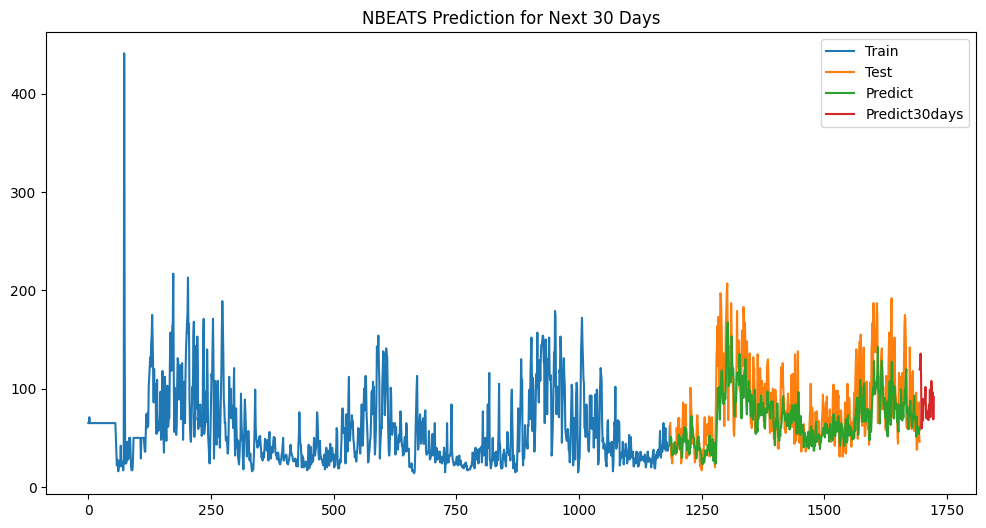

In [146]:
plt.figure(figsize=(12, 6))
future_forecast_array = np.array(future_forecast_30)
train_data_index = pd.RangeIndex(start=0, stop=split_size, step=1)
plt.plot(y_train)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
plt.plot(test_data_index,y_test)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
len(test_data_index)
plt.plot(test_data_index,model_preds)
prediect_data_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+29, step=1)
plt.plot(prediect_data_index,future_forecast_array)
plt.title('NBEATS Prediction for Next 30 Days')
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

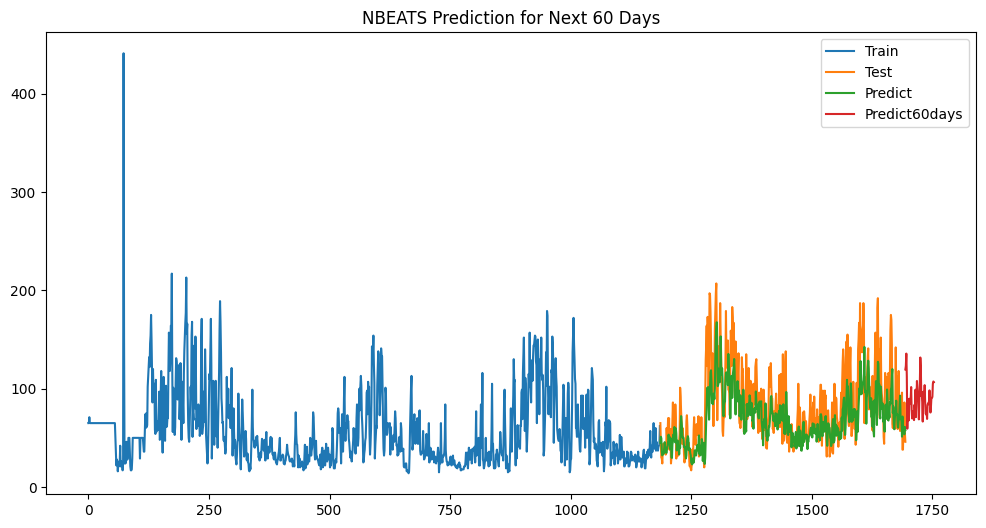

In [147]:
plt.figure(figsize=(12, 6))
future_forecast_array_60 = np.array(future_forecast_60)
train_data_index = pd.RangeIndex(start=0, stop=split_size, step=1)
plt.plot(y_train)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
plt.plot(test_data_index,y_test)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
len(test_data_index)
plt.plot(test_data_index,model_preds)
prediect_data_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+59, step=1)
plt.plot(prediect_data_index,future_forecast_array_60)
plt.title('NBEATS Prediction for Next 60 Days')
plt.legend(['Train','Test','Predict','Predict60days'])
plt.show()

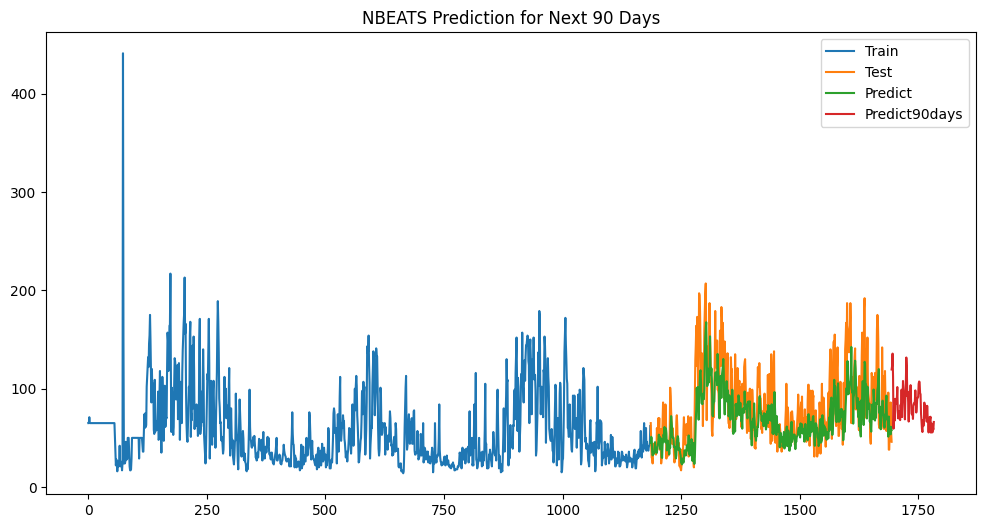

In [148]:
plt.figure(figsize=(12, 6))
future_forecast_array_90 = np.array(future_forecast_90)
train_data_index = pd.RangeIndex(start=0, stop=split_size, step=1)
plt.plot(y_train)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
plt.plot(test_data_index,y_test)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
len(test_data_index)
plt.plot(test_data_index,model_preds)
prediect_data_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+89, step=1)
plt.plot(prediect_data_index,future_forecast_array_90)
plt.title('NBEATS Prediction for Next 90 Days')
plt.legend(['Train','Test','Predict','Predict90days'])
plt.show()

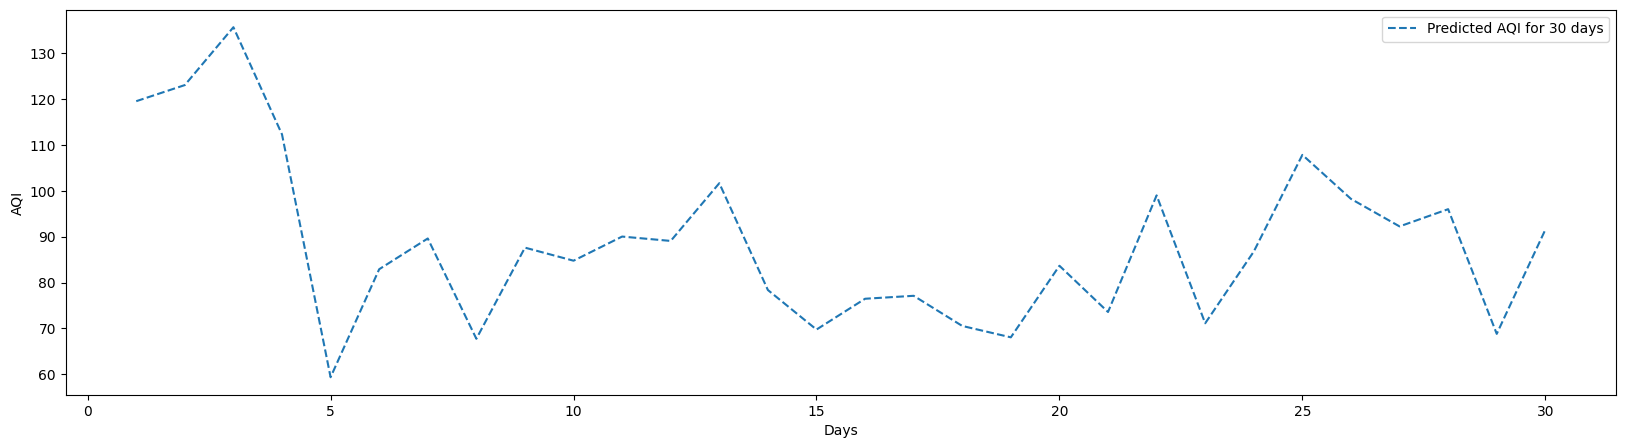

In [149]:
plt.figure(figsize=(20,5))
plt.plot(range(1, 30 + 1), future_forecast_30 , label=f'Predicted AQI for {30} days', linestyle='--')
plt.xlabel('Days')
plt.ylabel('AQI')
plt.legend()
plt.show()

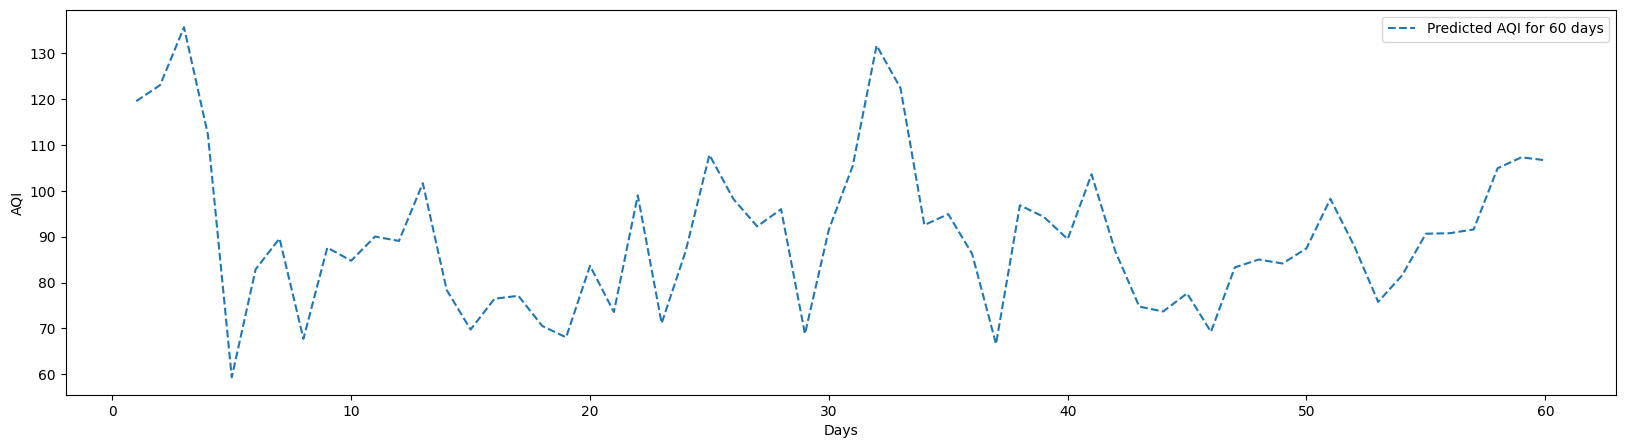

In [150]:
plt.figure(figsize=(20,5))
plt.plot(range(1, 60 + 1), future_forecast_60 , label=f'Predicted AQI for {60} days', linestyle='--')
plt.xlabel('Days')
plt.ylabel('AQI')
plt.legend()
plt.show()

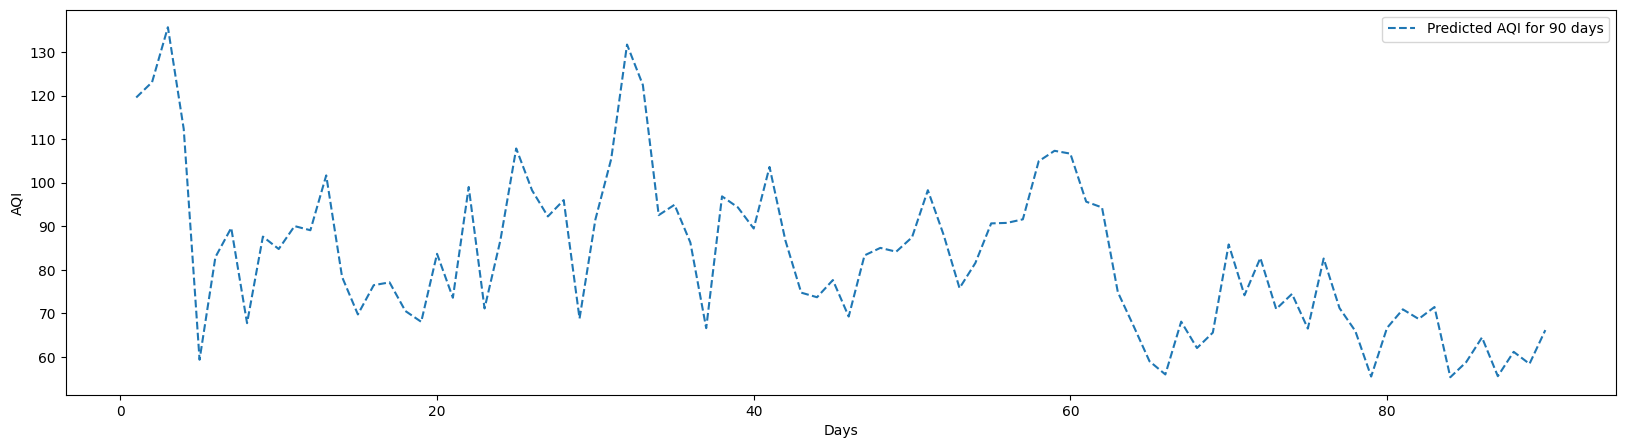

In [151]:
plt.figure(figsize=(20,5))
plt.plot(range(1, 90 + 1), future_forecast_90 , label=f'Predicted AQI for {90} days', linestyle='--')
plt.xlabel('Days')
plt.ylabel('AQI')
plt.legend()
plt.show()

**NBEATS(8:2)**


In [152]:
WINDOW_SIZE=90
HORIZON=1
df_aqi

,AQI
date,
2019-05-03,65
2019-05-04,65
2019-05-05,71
2019-05-06,65
2019-05-07,65
...,...
2024-02-26,62
2024-02-27,47
2024-02-28,86


In [153]:
aqi_nbeats = df_aqi.copy()
for i in range(WINDOW_SIZE):
  aqi_nbeats[f"AQI+{i+1}"] = aqi_nbeats["AQI"].shift(periods=i+1)
aqi_nbeats.dropna()

,AQI,AQI+1,AQI+2,AQI+3,AQI+4,AQI+5,AQI+6,AQI+7,AQI+8,AQI+9,...,AQI+81,AQI+82,AQI+83,AQI+84,AQI+85,AQI+86,AQI+87,AQI+88,AQI+89,AQI+90
date,,,,,,,,,,,,,,,,,,,,,
2019-08-03,18,17.0,17.0,21.0,34.0,50.0,50.0,50.0,29.0,28.0,...,65.0,65.0,65.0,65.0,65.0,65.0,65.0,71.0,65.0,65.0
2019-08-04,29,18.0,17.0,17.0,21.0,34.0,50.0,50.0,50.0,29.0,...,65.0,65.0,65.0,65.0,65.0,65.0,65.0,65.0,71.0,65.0
2019-08-05,50,29.0,18.0,17.0,17.0,21.0,34.0,50.0,50.0,50.0,...,65.0,65.0,65.0,65.0,65.0,65.0,65.0,65.0,65.0,71.0
2019-08-06,50,50.0,29.0,18.0,17.0,17.0,21.0,34.0,50.0,50.0,...,65.0,65.0,65.0,65.0,65.0,65.0,65.0,65.0,65.0,65.0
2019-08-07,50,50.0,50.0,29.0,18.0,17.0,17.0,21.0,34.0,50.0,...,65.0,65.0,65.0,65.0,65.0,65.0,65.0,65.0,65.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-26,62,38.0,38.0,96.0,70.0,78.0,75.0,57.0,68.0,89.0,...,65.0,172.0,187.0,164.0,160.0,137.0,140.0,150.0,152.0,187.0
2024-02-27,47,62.0,38.0,38.0,96.0,70.0,78.0,75.0,57.0,68.0,...,103.0,65.0,172.0,187.0,164.0,160.0,137.0,140.0,150.0,152.0
2024-02-28,86,47.0,62.0,38.0,38.0,96.0,70.0,78.0,75.0,57.0,...,107.0,103.0,65.0,172.0,187.0,164.0,160.0,137.0,140.0,150.0


In [154]:
# Make features and labels
x = aqi_nbeats.drop("AQI", axis=1)
y = aqi_nbeats["AQI"]
x.fillna(method='ffill', inplace=True)
x.fillna(method='bfill', inplace=True)
y.fillna(method='ffill', inplace=True)
y.fillna(method='bfill', inplace=True)

In [155]:
split_size = int(len(x) * 0.8)
x_train, y_train = x[:split_size], y[:split_size]
x_test, y_test = x[split_size:], y[split_size:]
len(x_train), len(y_train), len(x_test), len(y_test)

(1356, 1356, 339, 339)

In [156]:
#Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(x_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

#Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 90), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 90), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [157]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 20 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30
INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON
INPUT_SIZE, THETA_SIZE

(90, 91)

In [158]:
# trying tf.keras.layers.add or .subtract
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

subtracted = tf.keras.layers.subtract([tensor_1,tensor_2])
added = tf.keras.layers.add([tensor_1,tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


In [159]:
tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = tf.keras.layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)

residuals = tf.keras.layers.subtract([stack_input, backcast], name=f"subtract_00")

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = tf.keras.layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = tf.keras.layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])

In [160]:
model.evaluate(test_dataset)

1/1 [==============================] - 1s 522ms/step - loss: 21.2083 - mae: 21.2083 - mse: 764.1597


[21.208290100097656, 21.208290100097656, 764.15966796875]

In [161]:
def make_preds(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)


def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  return {"mae": mae.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy()}

In [162]:
model_preds = make_preds(model, test_dataset)
model_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_preds)
model_results

1/1 [==============================] - 2s 2s/step


{'mae': 21.20829, 'rmse': 27.643438, 'mape': 25.619474}

In [163]:
INTO_FUTURE = 30
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  #Make an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] # only want preds from the last window (this will get updated)

  #Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time
  for _ in range(into_future):

    # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())
    # print(future_forecast)

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

  return future_forecast

In [164]:
future_forecast_30 = make_future_forecast(values=y,
                                       model=model,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

future_forecast_60 = make_future_forecast(values=y,
                                       model=model,
                                       into_future=INTO_FUTURE+30,
                                       window_size=WINDOW_SIZE)
future_forecast_90 = make_future_forecast(values=y,
                                       model=model,
                                       into_future=INTO_FUTURE+60,
                                       window_size=WINDOW_SIZE)

1/1 [==============================] - 2s 2s/step
Predicting on: 
 date
2023-11-27    160
2023-11-28    164
2023-11-29    187
2023-11-30    172
2023-12-01     65
             ... 
2024-02-26     62
2024-02-27     47
2024-02-28     86
2024-02-29     55
2024-03-01     46
Name: AQI, Length: 90, dtype: int64 -> Prediction: 118.12115478515625

1/1 [==============================] - 2s 2s/step
Predicting on: 
 [164.         187.         172.          65.         103.
 107.          69.         112.         109.         119.
 133.         141.          79.          88.         102.
  79.          87.          75.          73.          58.
 113.          57.          57.         100.          98.
 134.         157.          78.          78.         104.
 182.         192.         118.         140.          98.
  70.         122.         152.         106.          95.
  90.          82.          83.          51.          44.
  82.         116.         108.         100.         112.
  95.       

In [165]:
y_train = aqi_arr[:split_size]
y_train = aqi_arr[:split_size]
y_test = aqi_arr[split_size:]
len(y_train), len(y_test)
test_size = len(df)-split_size
future_forecast_array = np.array(future_forecast_30)

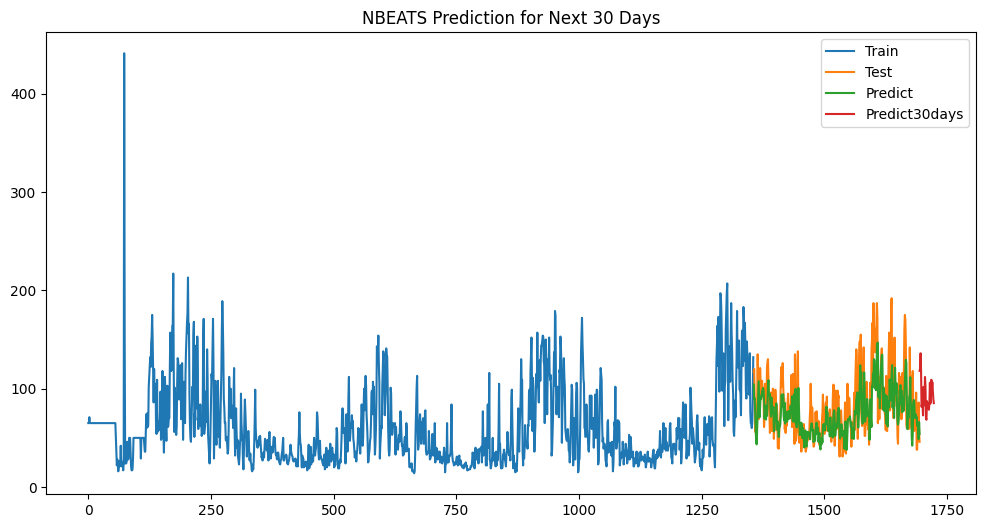

In [166]:
plt.figure(figsize=(12, 6))
train_data_index = pd.RangeIndex(start=0, stop=split_size, step=1)
plt.plot(y_train)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
plt.plot(test_data_index,y_test)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
len(test_data_index)
plt.plot(test_data_index,model_preds)
prediect_data_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+29, step=1)
plt.plot(prediect_data_index,future_forecast_array)
plt.title('NBEATS Prediction for Next 30 Days')
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

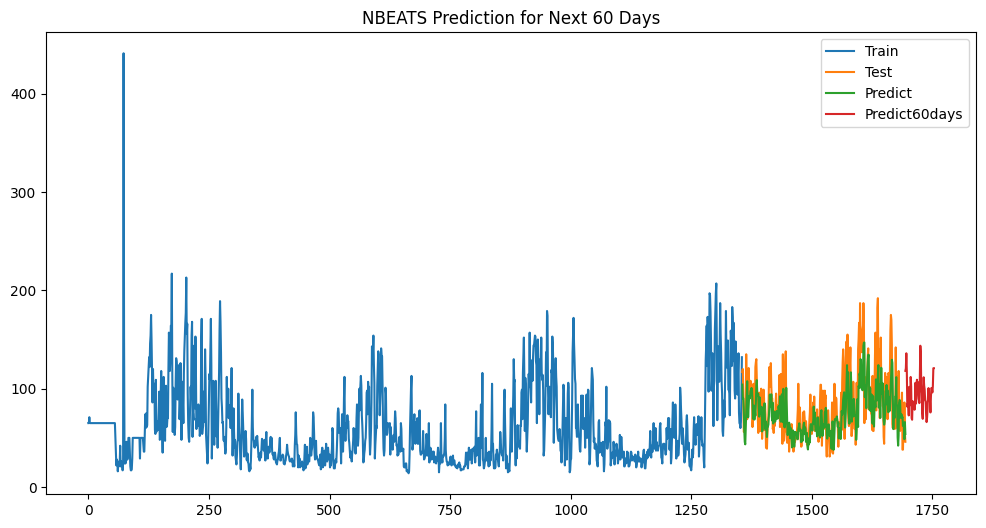

In [167]:
plt.figure(figsize=(12, 6))
future_forecast_array_60 = np.array(future_forecast_60)
train_data_index = pd.RangeIndex(start=0, stop=split_size, step=1)
plt.plot(y_train)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
plt.plot(test_data_index,y_test)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
len(test_data_index)
plt.plot(test_data_index,model_preds)
prediect_data_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+59, step=1)
plt.plot(prediect_data_index,future_forecast_array_60)
plt.title('NBEATS Prediction for Next 60 Days')
plt.legend(['Train','Test','Predict','Predict60days'])
plt.show()

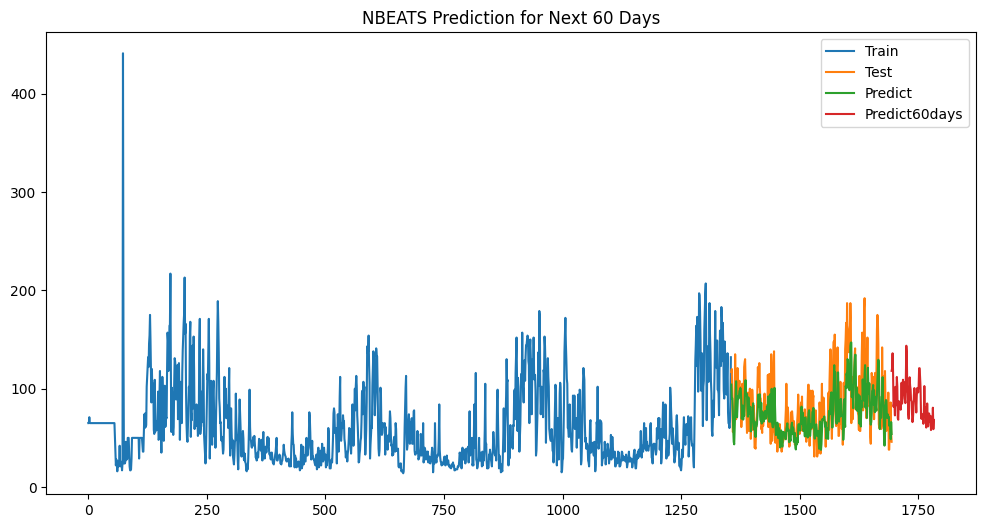

In [168]:
plt.figure(figsize=(12, 6))
future_forecast_array_90 = np.array(future_forecast_90)
train_data_index = pd.RangeIndex(start=0, stop=split_size, step=1)
plt.plot(y_train)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
plt.plot(test_data_index,y_test)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
len(test_data_index)
plt.plot(test_data_index,model_preds)
prediect_data_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+89, step=1)
plt.plot(prediect_data_index,future_forecast_array_90)
plt.title('NBEATS Prediction for Next 60 Days')
plt.legend(['Train','Test','Predict','Predict60days'])
plt.show()

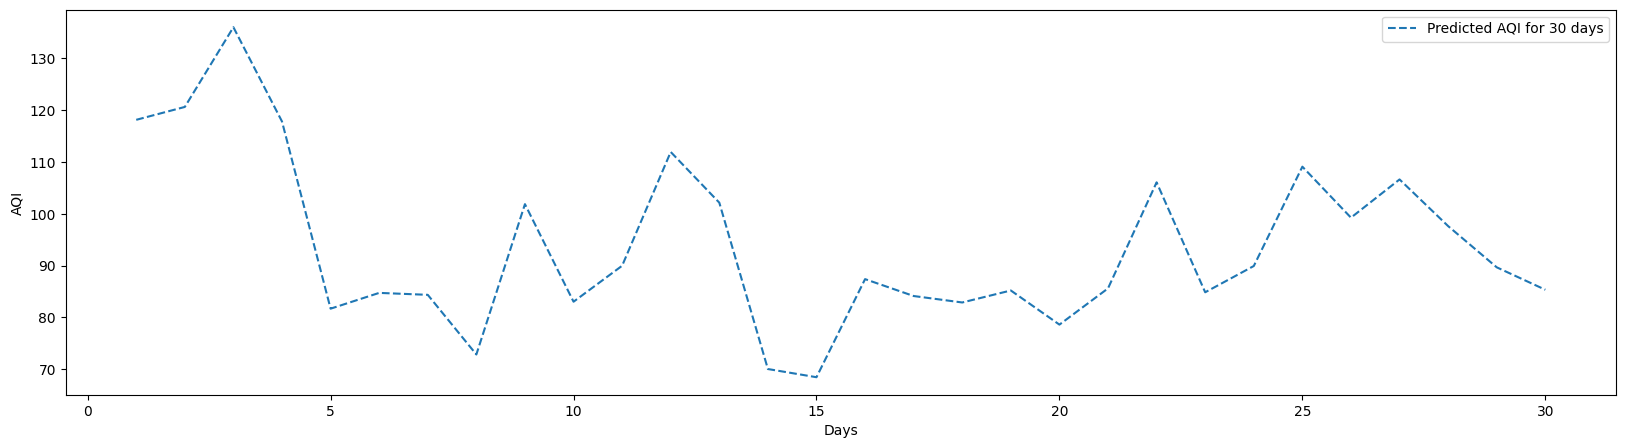

In [169]:
plt.figure(figsize=(20,5))
plt.plot(range(1, 30 + 1), future_forecast_30 , label=f'Predicted AQI for {30} days', linestyle='--')
plt.xlabel('Days')
plt.ylabel('AQI')
plt.legend()
plt.show()

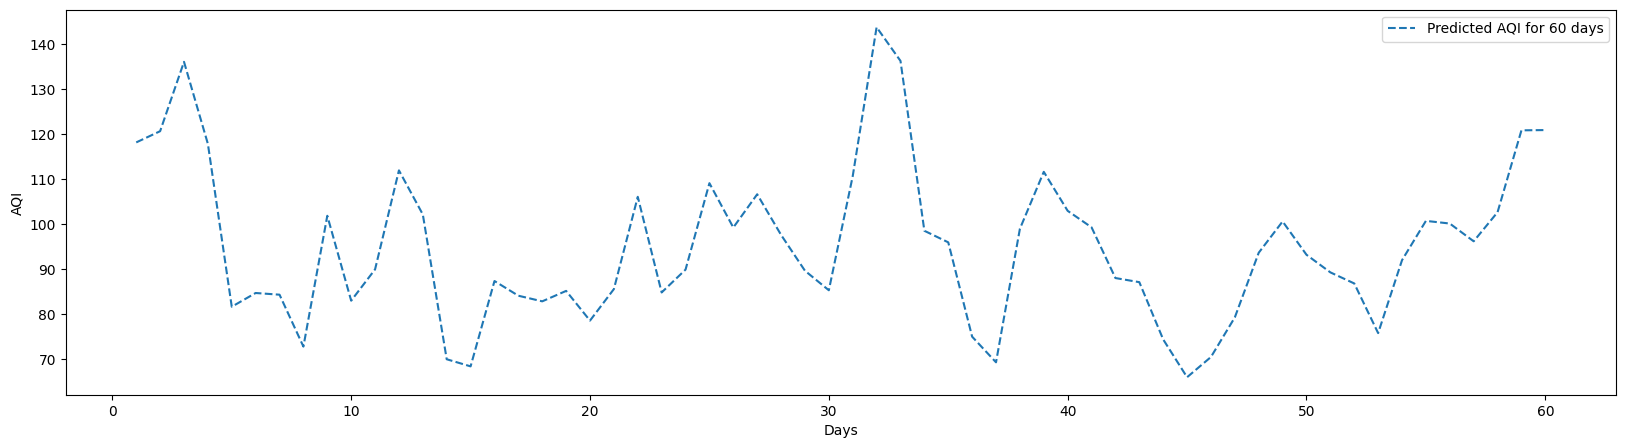

In [170]:
plt.figure(figsize=(20,5))
plt.plot(range(1, 60 + 1), future_forecast_60 , label=f'Predicted AQI for {60} days', linestyle='--')
plt.xlabel('Days')
plt.ylabel('AQI')
plt.legend()
plt.show()

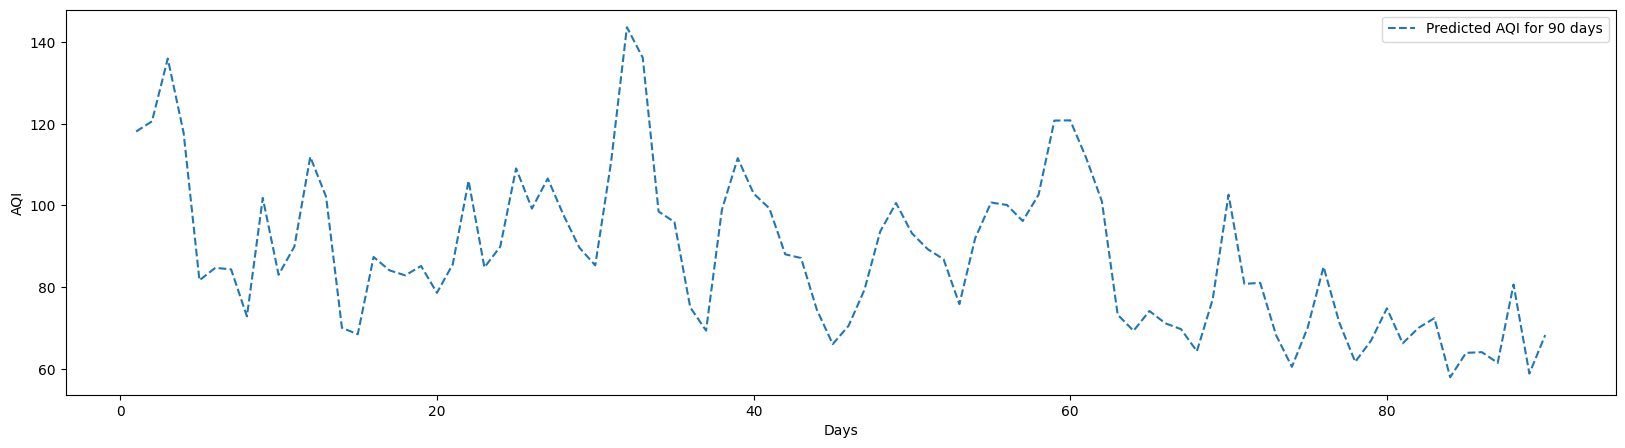

In [171]:
plt.figure(figsize=(20,5))
plt.plot(range(1, 90 + 1), future_forecast_90 , label=f'Predicted AQI for {90} days', linestyle='--')
plt.xlabel('Days')
plt.ylabel('AQI')
plt.legend()
plt.show()

**NBEAT(9:1)**

In [172]:
WINDOW_SIZE=90
HORIZON=1
aqi_nbeats = df_aqi.copy()
for i in range(WINDOW_SIZE):
  aqi_nbeats[f"AQI+{i+1}"] = aqi_nbeats["AQI"].shift(periods=i+1)
aqi_nbeats.dropna()

,AQI,AQI+1,AQI+2,AQI+3,AQI+4,AQI+5,AQI+6,AQI+7,AQI+8,AQI+9,...,AQI+81,AQI+82,AQI+83,AQI+84,AQI+85,AQI+86,AQI+87,AQI+88,AQI+89,AQI+90
date,,,,,,,,,,,,,,,,,,,,,
2019-08-03,18,17.0,17.0,21.0,34.0,50.0,50.0,50.0,29.0,28.0,...,65.0,65.0,65.0,65.0,65.0,65.0,65.0,71.0,65.0,65.0
2019-08-04,29,18.0,17.0,17.0,21.0,34.0,50.0,50.0,50.0,29.0,...,65.0,65.0,65.0,65.0,65.0,65.0,65.0,65.0,71.0,65.0
2019-08-05,50,29.0,18.0,17.0,17.0,21.0,34.0,50.0,50.0,50.0,...,65.0,65.0,65.0,65.0,65.0,65.0,65.0,65.0,65.0,71.0
2019-08-06,50,50.0,29.0,18.0,17.0,17.0,21.0,34.0,50.0,50.0,...,65.0,65.0,65.0,65.0,65.0,65.0,65.0,65.0,65.0,65.0
2019-08-07,50,50.0,50.0,29.0,18.0,17.0,17.0,21.0,34.0,50.0,...,65.0,65.0,65.0,65.0,65.0,65.0,65.0,65.0,65.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-26,62,38.0,38.0,96.0,70.0,78.0,75.0,57.0,68.0,89.0,...,65.0,172.0,187.0,164.0,160.0,137.0,140.0,150.0,152.0,187.0
2024-02-27,47,62.0,38.0,38.0,96.0,70.0,78.0,75.0,57.0,68.0,...,103.0,65.0,172.0,187.0,164.0,160.0,137.0,140.0,150.0,152.0
2024-02-28,86,47.0,62.0,38.0,38.0,96.0,70.0,78.0,75.0,57.0,...,107.0,103.0,65.0,172.0,187.0,164.0,160.0,137.0,140.0,150.0


In [173]:
# Make features and labels
x = aqi_nbeats.drop("AQI", axis=1)
y = aqi_nbeats["AQI"]
x.fillna(method='ffill', inplace=True)
x.fillna(method='bfill', inplace=True)
y.fillna(method='ffill', inplace=True)
y.fillna(method='bfill', inplace=True)

In [174]:
split_size = int(len(x) * 0.9)
x_train, y_train = x[:split_size], y[:split_size]
x_test, y_test = x[split_size:], y[split_size:]
len(x_train), len(y_train), len(x_test), len(y_test)

(1525, 1525, 170, 170)

In [175]:
#Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(x_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

#Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 90), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 90), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [176]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 20 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30
INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON
INPUT_SIZE, THETA_SIZE

(90, 91)

In [177]:
# trying tf.keras.layers.add or .subtract
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

subtracted = tf.keras.layers.subtract([tensor_1,tensor_2])
added = tf.keras.layers.add([tensor_1,tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


In [178]:
tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = tf.keras.layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)

residuals = tf.keras.layers.subtract([stack_input, backcast], name=f"subtract_00")

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = tf.keras.layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = tf.keras.layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])

In [179]:
model.evaluate(test_dataset)

1/1 [==============================] - 0s 176ms/step - loss: 26.1216 - mae: 26.1216 - mse: 1004.0381


[26.12160873413086, 26.12160873413086, 1004.0381469726562]

In [180]:
model.evaluate(test_dataset)
def make_preds(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)


def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  return {"mae": mae.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy()}

1/1 [==============================] - 0s 192ms/step - loss: 26.1216 - mae: 26.1216 - mse: 1004.0381


In [181]:
model_preds = make_preds(model, test_dataset)
model_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_preds)
model_results

1/1 [==============================] - 2s 2s/step


{'mae': 26.121609, 'rmse': 31.686562, 'mape': 33.0775}

In [182]:
INTO_FUTURE = 30
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  #Make an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] # only want preds from the last window (this will get updated)

  #Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time
  for _ in range(into_future):

    # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())
    # print(future_forecast)

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

  return future_forecast

In [183]:
future_forecast_30 = make_future_forecast(values=y,
                                       model=model,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

future_forecast_60 = make_future_forecast(values=y,
                                       model=model,
                                       into_future=INTO_FUTURE+30,
                                       window_size=WINDOW_SIZE)
future_forecast_90 = make_future_forecast(values=y,
                                       model=model,
                                       into_future=INTO_FUTURE+60,
                                       window_size=WINDOW_SIZE)

1/1 [==============================] - 2s 2s/step
Predicting on: 
 date
2023-11-27    160
2023-11-28    164
2023-11-29    187
2023-11-30    172
2023-12-01     65
             ... 
2024-02-26     62
2024-02-27     47
2024-02-28     86
2024-02-29     55
2024-03-01     46
Name: AQI, Length: 90, dtype: int64 -> Prediction: 134.39251708984375

1/1 [==============================] - 2s 2s/step
Predicting on: 
 [164.         187.         172.          65.         103.
 107.          69.         112.         109.         119.
 133.         141.          79.          88.         102.
  79.          87.          75.          73.          58.
 113.          57.          57.         100.          98.
 134.         157.          78.          78.         104.
 182.         192.         118.         140.          98.
  70.         122.         152.         106.          95.
  90.          82.          83.          51.          44.
  82.         116.         108.         100.         112.
  95.       

In [184]:
y_train = aqi_arr[:split_size]
y_train = aqi_arr[:split_size]
y_test = aqi_arr[split_size:]
len(y_train), len(y_test)
test_size = len(df)-split_size
future_forecast_array = np.array(future_forecast_30)

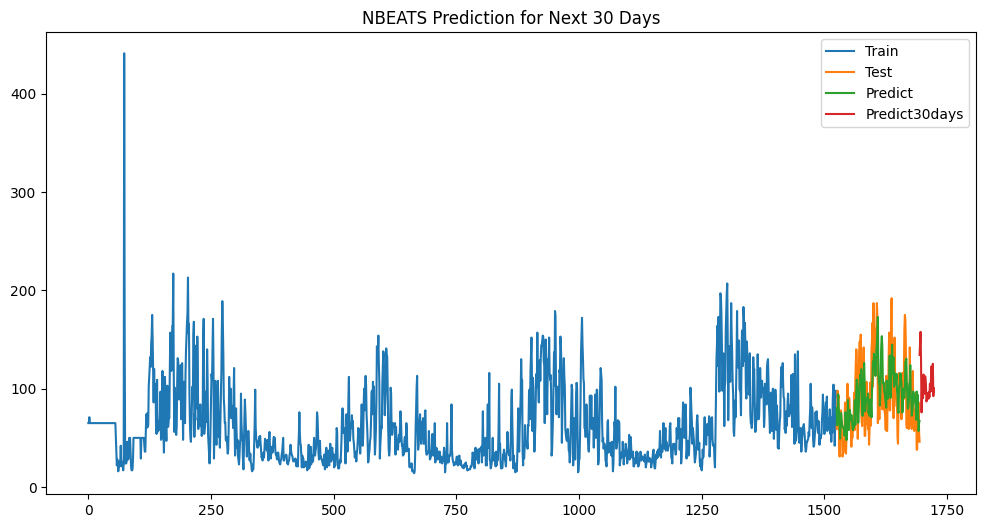

In [185]:
plt.figure(figsize=(12, 6))
train_data_index = pd.RangeIndex(start=0, stop=split_size, step=1)
plt.plot(y_train)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
plt.plot(test_data_index,y_test)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
len(test_data_index)
plt.plot(test_data_index,model_preds)
prediect_data_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+29, step=1)
plt.plot(prediect_data_index,future_forecast_array)
plt.title('NBEATS Prediction for Next 30 Days')
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

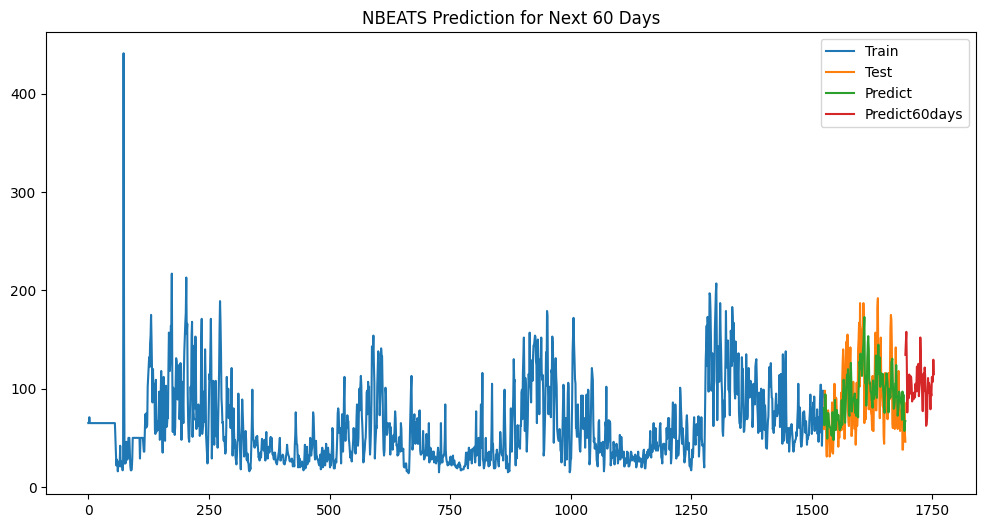

In [186]:
plt.figure(figsize=(12, 6))
future_forecast_array_60 = np.array(future_forecast_60)
train_data_index = pd.RangeIndex(start=0, stop=split_size, step=1)
plt.plot(y_train)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
plt.plot(test_data_index,y_test)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
len(test_data_index)
plt.plot(test_data_index,model_preds)
prediect_data_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+59, step=1)
plt.plot(prediect_data_index,future_forecast_array_60)
plt.title('NBEATS Prediction for Next 60 Days')
plt.legend(['Train','Test','Predict','Predict60days'])
plt.show()

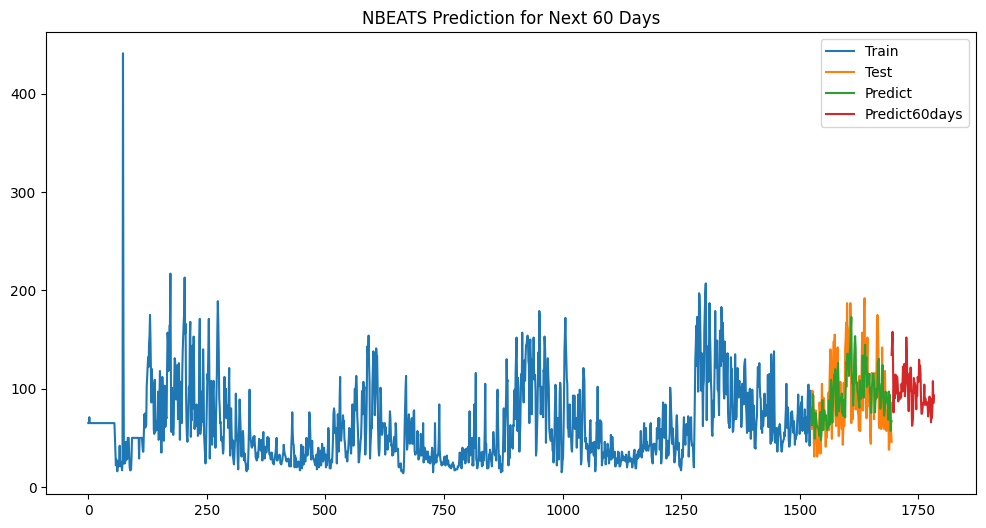

In [187]:
plt.figure(figsize=(12, 6))
future_forecast_array_90 = np.array(future_forecast_90)
train_data_index = pd.RangeIndex(start=0, stop=split_size, step=1)
plt.plot(y_train)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
plt.plot(test_data_index,y_test)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
len(test_data_index)
plt.plot(test_data_index,model_preds)
prediect_data_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+89, step=1)
plt.plot(prediect_data_index,future_forecast_array_90)
plt.title('NBEATS Prediction for Next 60 Days')
plt.legend(['Train','Test','Predict','Predict60days'])
plt.show()

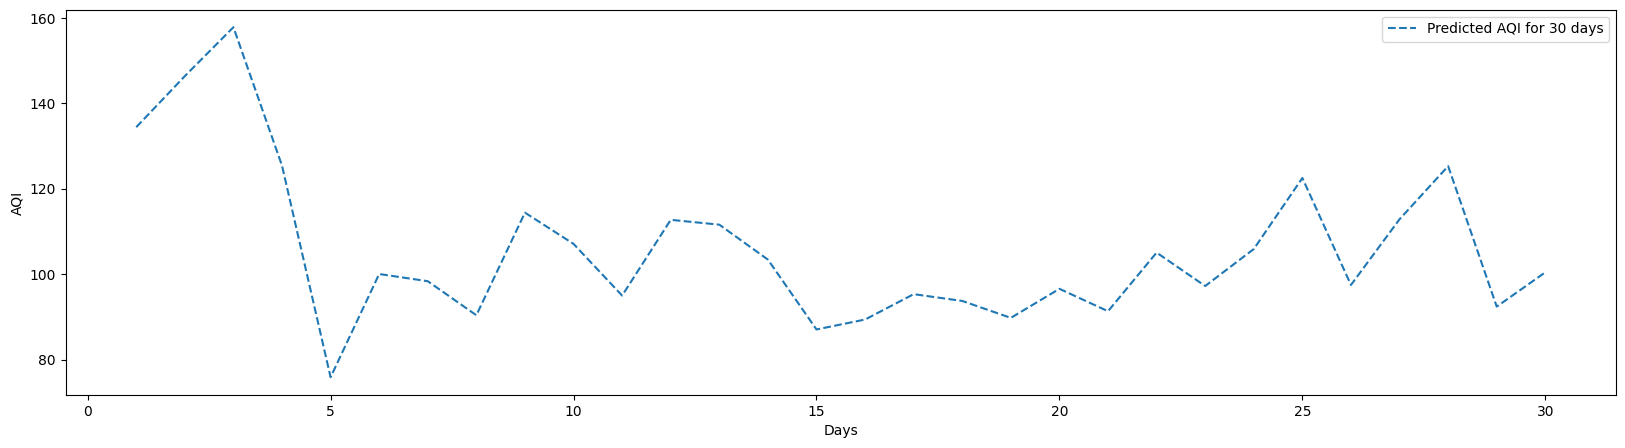

In [188]:
plt.figure(figsize=(20,5))
plt.plot(range(1, 30 + 1), future_forecast_30 , label=f'Predicted AQI for {30} days', linestyle='--')
plt.xlabel('Days')
plt.ylabel('AQI')
plt.legend()
plt.show()

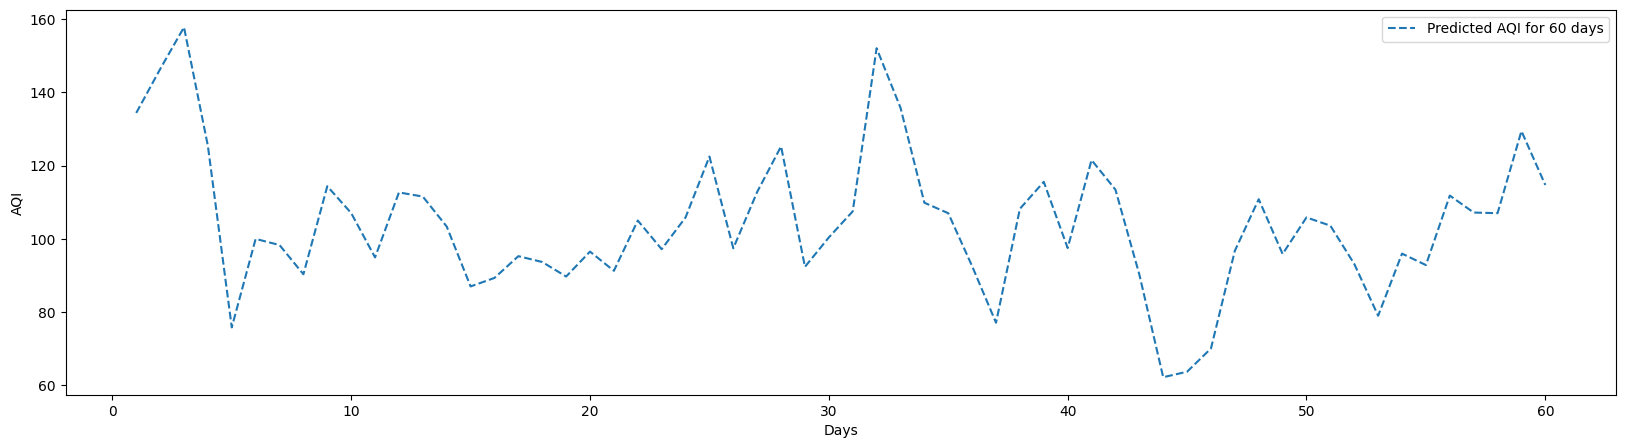

In [189]:
plt.figure(figsize=(20,5))
plt.plot(range(1, 60 + 1), future_forecast_60 , label=f'Predicted AQI for {60} days', linestyle='--')
plt.xlabel('Days')
plt.ylabel('AQI')
plt.legend()
plt.show()

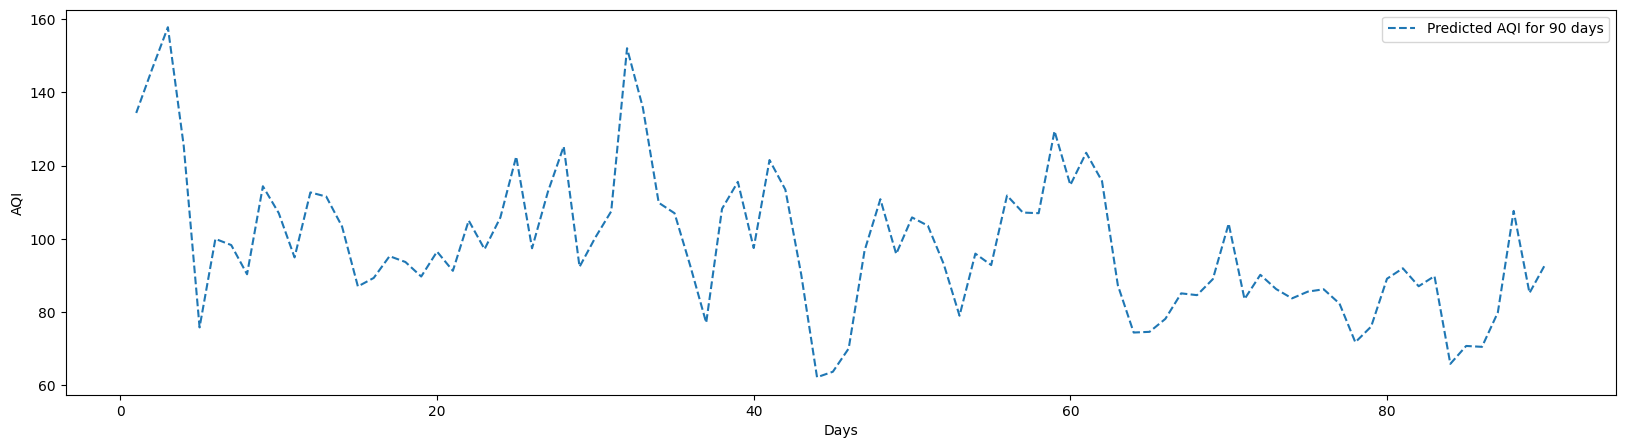

In [191]:
plt.figure(figsize=(20,5))
plt.plot(range(1, 90 + 1), future_forecast_90 , label=f'Predicted AQI for {90} days', linestyle='--')
plt.xlabel('Days')
plt.ylabel('AQI')
plt.legend()
plt.show()